In [10]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

# if (!requireNamespace("BiocManager", quietly=TRUE)) 
#     install.packages("BiocManager") 

# BiocManager::install("ComplexHeatmap")

In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [1]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '061325'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(gridtext)
library(IRanges)
library(ComplexHeatmap)
library(circlize)

# reading in file
full_df = data.frame(read_excel("Input/Processed_Data_061225.xlsx")) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [2]:
head(full_df)
dim(full_df)

,SampleID,Sample,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Cr,Chromium,97.32700000
2,WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Cu,Copper,5.70000000
3,WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Pb,Lead,5.00000000
4,WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Ti,Titanium,33.00000000
5,WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Zn,Zinc,22.00000000
6,WF_1289909_1,WF,1289909,Trieu et al. 2024,1,PAH,Volume,DTXSID0023878,Anthracene,0.06557439


[1] 4873   10

This analysis will use PCA to explore if chemical and metal concentrations of control, WS, and WF samples are similar using PCA.

In [3]:
# will run PCA on each class, so the df will be split
split_df = full_df %>%
    # removing outliers
    group_by(Metric) %>%
    group_split

vol_df = split_df[[1]]
weight_df = split_df[[2]]

head(vol_df)

SampleID,Sample,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Cr,Chromium,97.32700000
WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Cu,Copper,5.70000000
WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Pb,Lead,5.00000000
WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Ti,Titanium,33.00000000
WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Metal,Volume,Zn,Zinc,22.00000000
WF_1289909_1,WF,1289909,Trieu et al. 2024,1,PAH,Volume,DTXSID0023878,Anthracene,0.06557439


In [4]:
`%notin%` <- Negate(`%in%`) 

wider_vol_df = vol_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

wider_weight_df = weight_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

head(wider_vol_df)

,Sample,HAWC_ID,Study,Sample_Number,Metric,Cr,Cu,Pb,Ti,Zn,⋯,Co,Ni,As,Mo,Sr,V,DTXSID5023908,DTXSID9020409,DTXSID8024153,DTXSID3024289
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WF_1289909_1,WF,1289909,Trieu et al. 2024,1,Volume,97.327,5.700,5.0,33.000,22.000,⋯,0.1000,1.000,3119.259,6.786248,2.5000,0.63000,0.030,0.011,0.032,0.04
WF_1289885_1,WF,1289885,Samsonov et al. 2005,1,Volume,2800.000,2335.613,1000.0,400.000,2900.000,⋯,340.0000,1084.376,210.000,150.000000,170.0000,227.99919,9327.310,10597.937,5427.989,191607.66
WF_1289885_2,WF,1289885,Samsonov et al. 2005,2,Volume,2500.000,1650.626,600.0,5400.000,2700.000,⋯,292.2820,818.186,200.000,115.503600,165.2631,210.50774,11759.310,7116.620,5105.869,192662.72
WF_1289885_3,WF,1289885,Samsonov et al. 2005,3,Volume,3300.000,3383.863,1000.0,2100.000,2700.000,⋯,330.0000,1644.151,170000.000,180.000000,160.0000,612.86435,25063.570,19755.717,9381.189,433990.74
WF_1289885_4,WF,1289885,Samsonov et al. 2005,4,Volume,1100.000,1045.662,1400.0,6500.000,3500.000,⋯,220.0000,495.408,130.000,40.000000,120.0000,88.04905,7179.436,3268.209,2139.309,112092.45
WF_1289895_1,WF,1289895,Silberstein et al. 2023,1,Volume,306.343,476.990,378.9,623.109,4723.704,⋯,18.7206,136.503,131.822,23.183906,48.0605,0.62744,0.020,0.010,0.020,0.01


In [72]:
weight_df %>%
    filter(Name == 'DTXSID4075459')
    # select(-c("Name", "Class")) %>%
    # pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    # column_to_rownames(var = "SampleID")

SampleID,Sample,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>


# Principal Component Analysis (PCA)

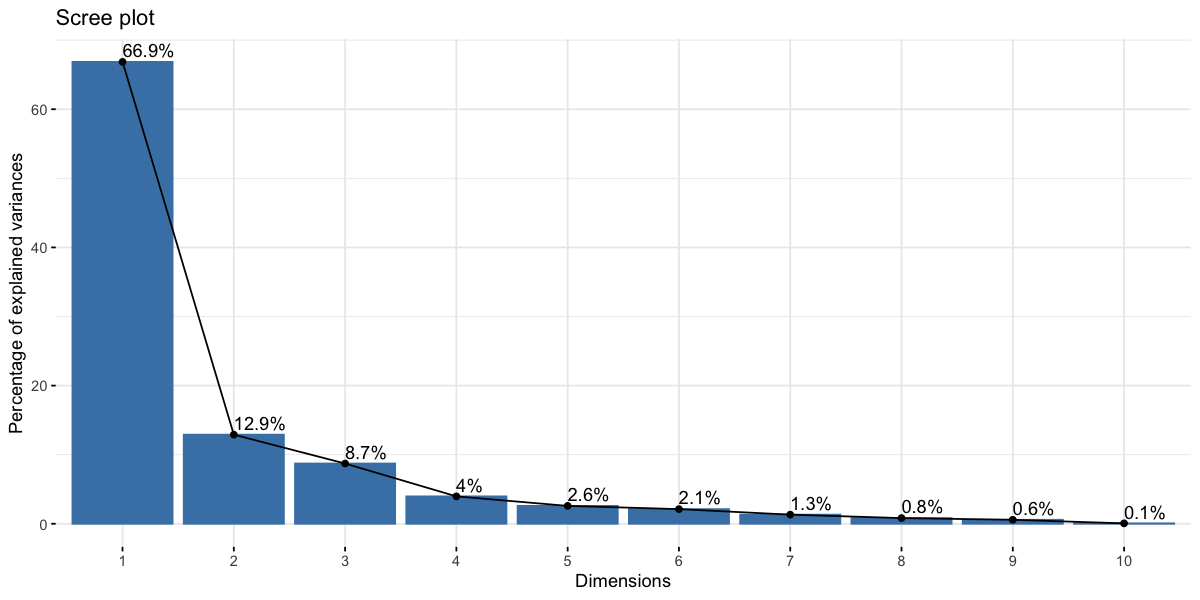

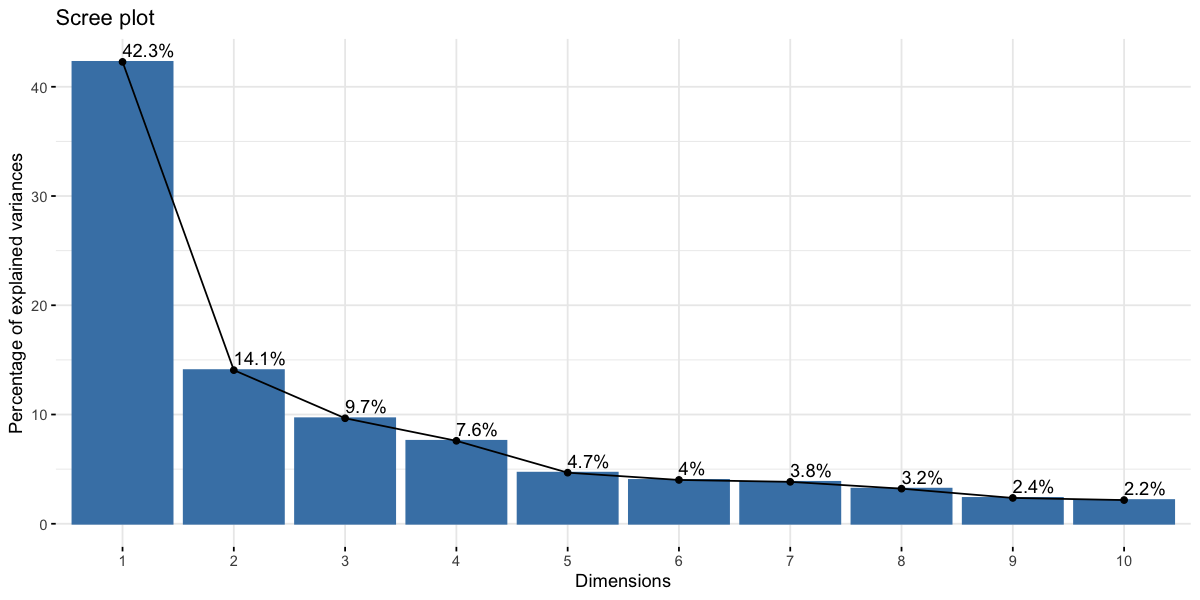

In [5]:
# setting seed for reproducibility
set.seed(12)

# running pca 
vol_pca = prcomp(wider_vol_df[,c(6:ncol(wider_vol_df))], center = TRUE, scale = TRUE)
weight_pca = prcomp(wider_weight_df[,c(6:ncol(wider_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(vol_pca, addlabels = TRUE)
fviz_eig(weight_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [6]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
vol_outliers = outlier_detection(vol_pca)
weight_outliers = outlier_detection(weight_pca)

In [7]:
# getting length
length(vol_outliers)
length(weight_outliers)

[1] 0

[1] 5

In [8]:
weight_outliers

[1] "WS_954974_1" "WS_279236_2" "WS_271571_1" "WS_271769_3" "WS_279236_1"

There were no outliers. (Removing those outliers.)

In [16]:
# removing those outliers
removed_wider_weight_df = wider_weight_df[rownames(wider_weight_df) %notin% weight_outliers,]

dim(removed_wider_weight_df)

[1] 117  39

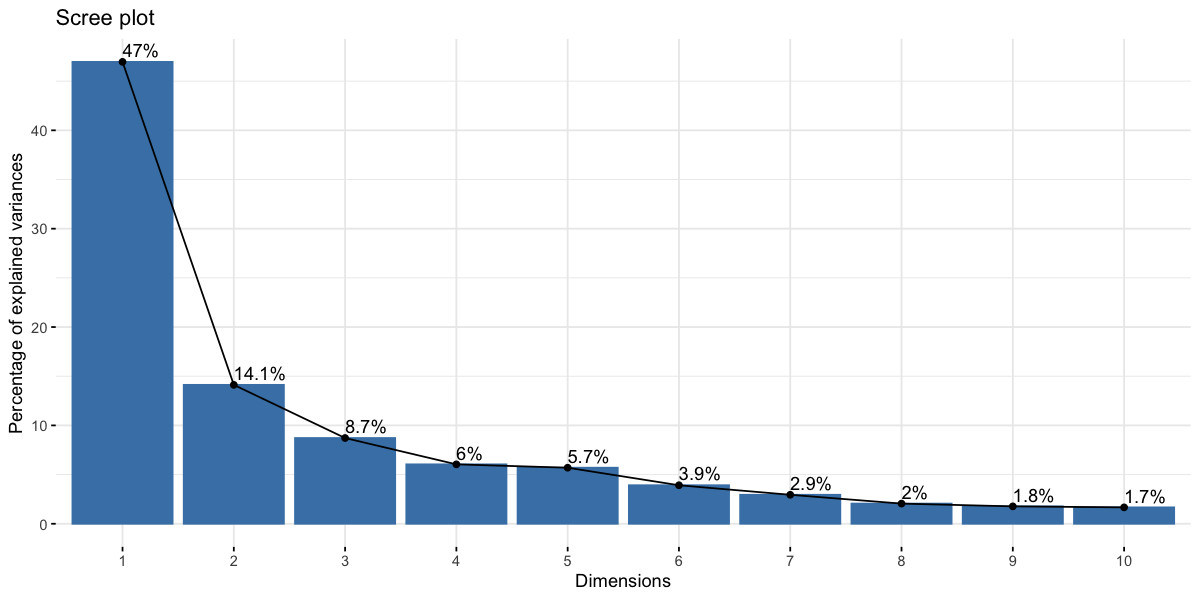

In [17]:
# rerunning pca
# setting seed for reproducibility
set.seed(12)

weight_pca = prcomp(removed_wider_weight_df[,c(6:ncol(removed_wider_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
fviz_eig(weight_pca, addlabels = TRUE)

In [19]:
# creating 1 df with eigenvectors and metadata
vol_pca_df = data.frame(vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
weight_pca_df = data.frame(weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID") 

more_data_df = rbind(wider_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(vol_pca_df, weight_pca_df), 
                                             more_data_df) %>%
    # cleaning variable names here
    mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,PC1,PC2,Sample,HAWC_ID,Study,Sample_Number,Metric
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,WF_1289909_1,-2.7216475,0.5874189,Wildfire,1289909,Trieu et al. 2024,1,Volume
2,WF_1289885_1,-0.0732955,-0.9958928,Wildfire,1289885,Samsonov et al. 2005,1,Volume
3,WF_1289885_2,-0.4874606,-0.7813317,Wildfire,1289885,Samsonov et al. 2005,2,Volume
4,WF_1289885_3,2.3286143,-1.3960328,Wildfire,1289885,Samsonov et al. 2005,3,Volume
5,WF_1289885_4,-1.4117901,-0.2112987,Wildfire,1289885,Samsonov et al. 2005,4,Volume
6,WF_1289895_1,-2.4949398,0.3543618,Wildfire,1289895,Silberstein et al. 2023,1,Volume


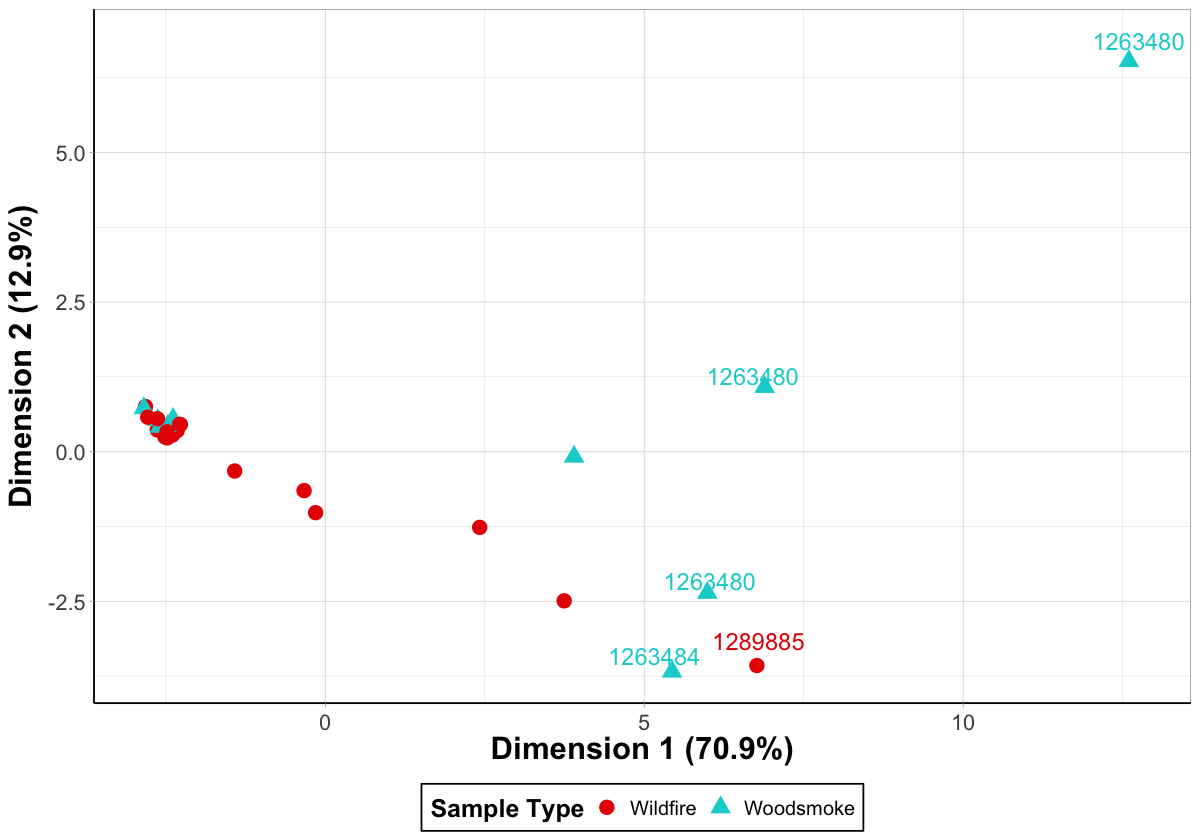

In [22]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol_pca_figure = ggplot() + 
  geom_point(data = full_eigenvector_df %>%
           filter(Metric == 'Volume'), aes(x = PC1, y = PC2, color = Sample, shape = Sample),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', PC1 > 5), 
                  aes(x = PC1, y = PC2, color = Sample, label = HAWC_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (70.9%)', y = 'Dimension 2 (12.9%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

vol_pca_figure

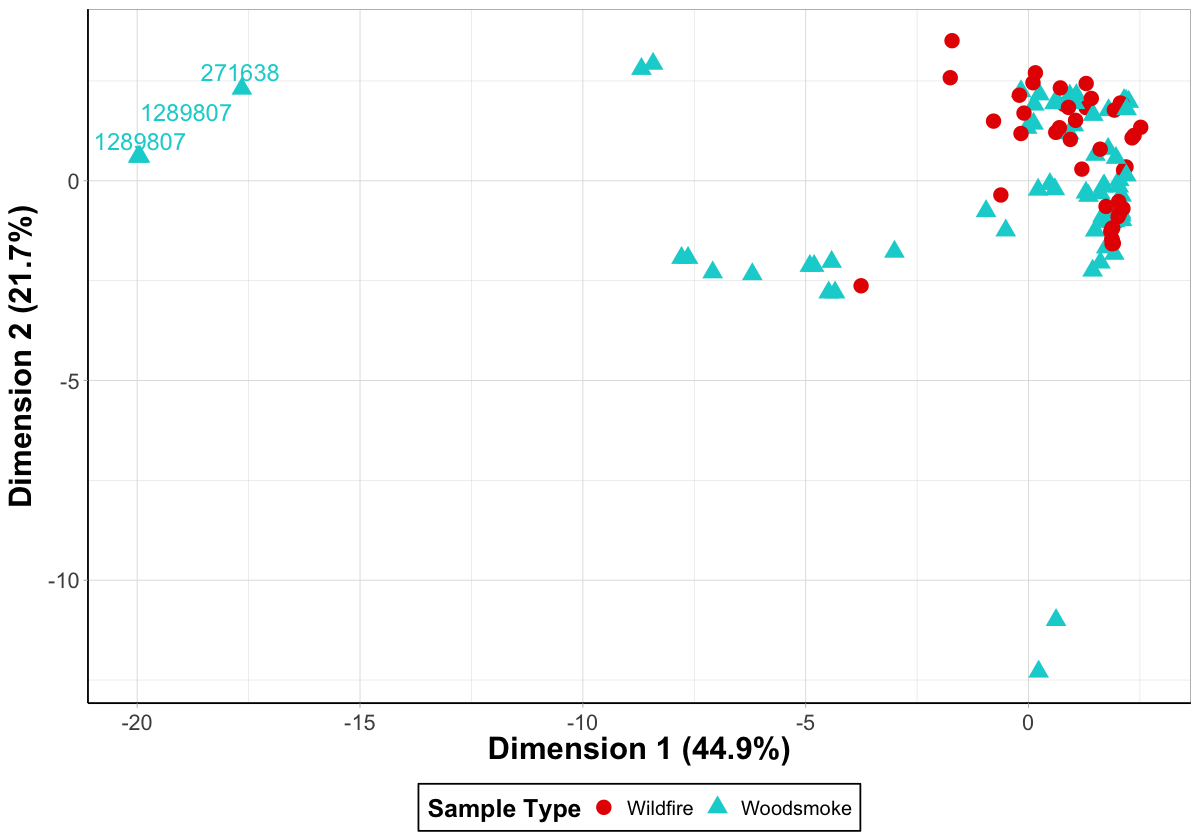

In [23]:
weight_pca_figure = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight'), 
       aes(x = PC1, y = PC2, color = Sample, shape = Sample)) + 
  geom_point(size = 4, position = position_jitter(w = 0.08)) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', PC1 < -10), 
                  aes(x = PC1, y = PC2, color = Sample, label = HAWC_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (44.9%)', y = 'Dimension 2 (21.7%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c('#e60000', '#00d2d2'))

weight_pca_figure

# Heatmaps

In [60]:
annotation_vol_col_df = unique(vol_df[,c("Class", "Name")]) %>%
    column_to_rownames(var = "Name")
annotation_vol_row_df = unique(vol_df[,c("SampleID", "Sample")]) %>%
    column_to_rownames(var = "SampleID") %>%
     mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))
annotation_weight_col_df = drop_na(unique(weight_df[,c("Class", "Name")])) %>%
    column_to_rownames(var = "Name")
annotation_weight_row_df = unique(weight_df[,c("SampleID", "Sample")]) %>%
    column_to_rownames(var = "SampleID") %>%
     mutate(Sample = ifelse(Sample == "WS", "Woodsmoke",
                                  ifelse(Sample == "WF", "Wildfire", Sample)))

head(annotation_vol_col_df)
head(annotation_vol_row_df)

,Class
,<chr>
Chromium,Metal
Copper,Metal
Lead,Metal
Titanium,Metal
Zinc,Metal
Anthracene,PAH


,Sample
,<chr>
WF_1289909_1,Wildfire
WF_1289885_1,Wildfire
WF_1289885_2,Wildfire
WF_1289885_3,Wildfire
WF_1289885_4,Wildfire
WF_1289895_1,Wildfire


In [52]:
# obtaining color palette
fall_colors = rev(palette(hcl.colors(10, "PiYG")))

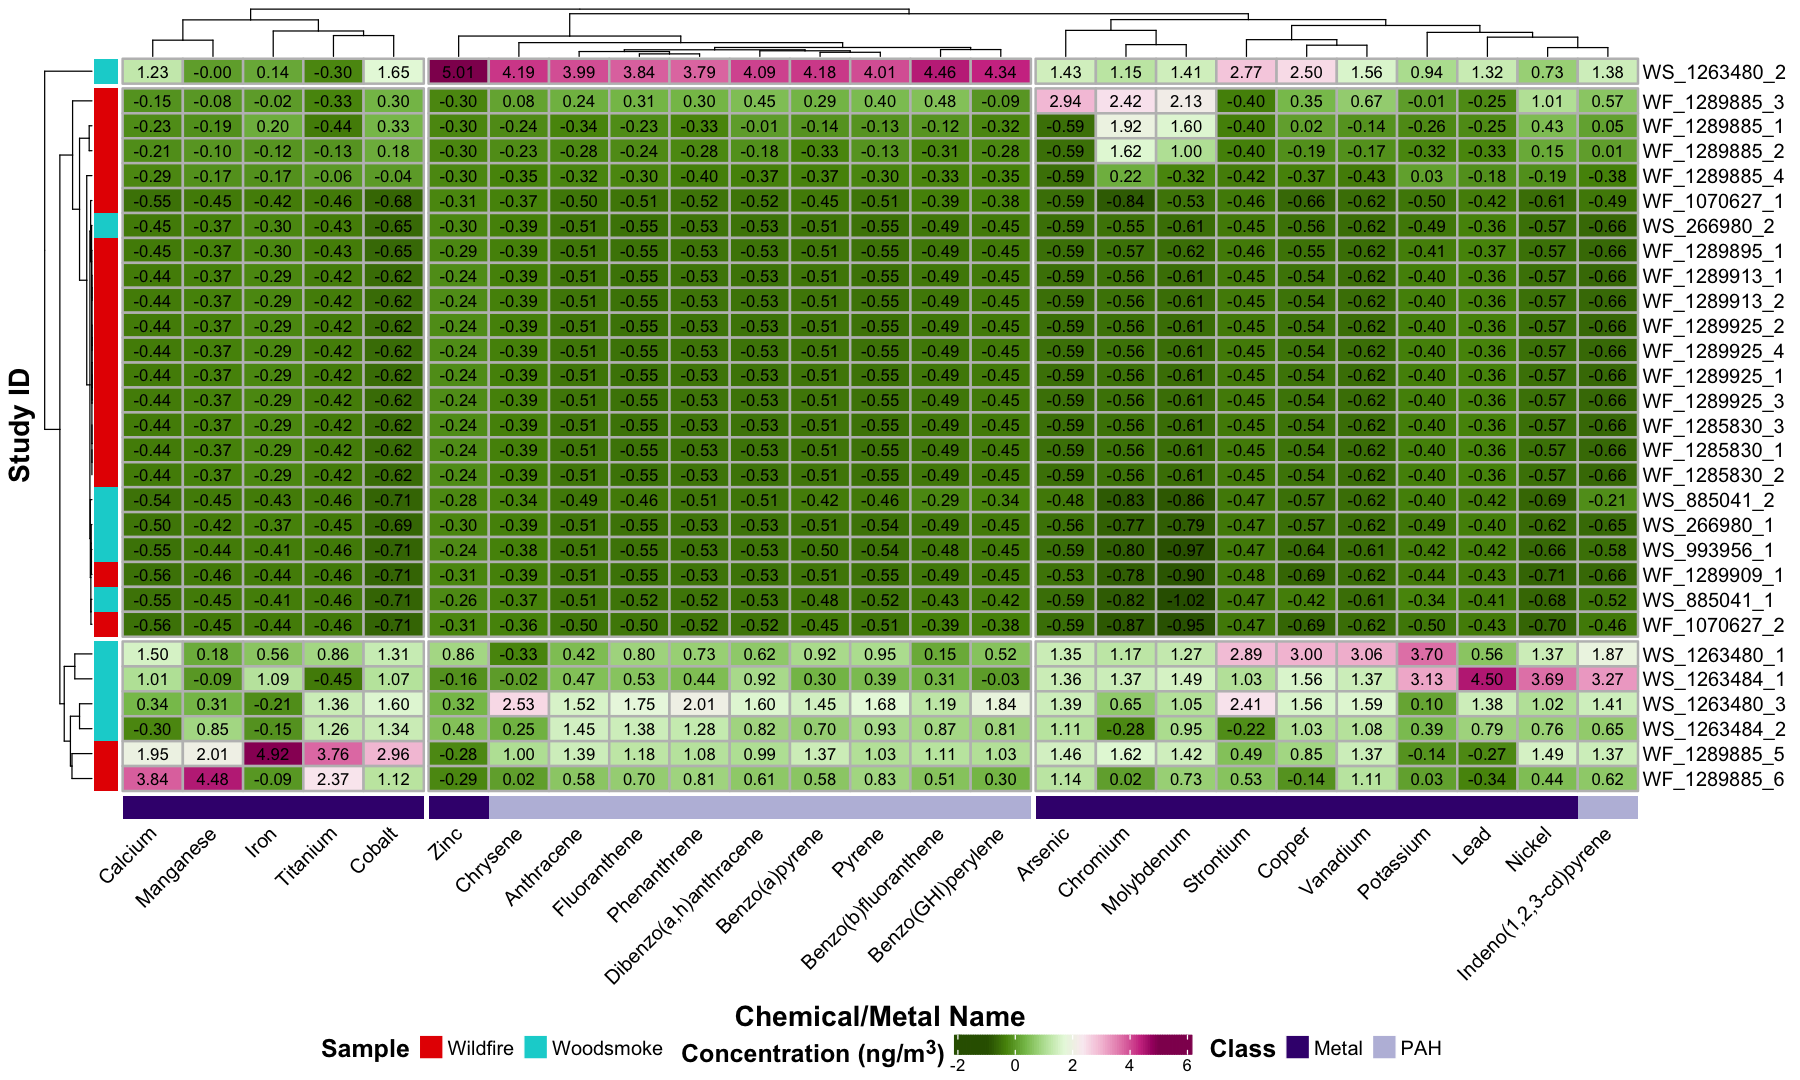

In [62]:
options(repr.plot.width=15, repr.plot.height=9) #changing size

wider_vol_df = vol_df %>%
    select(-c("DTXSID", "Class")) %>%
    pivot_wider(names_from = "Name", values_from = "Value") %>%
    column_to_rownames(var = "SampleID") 

vol_map = Heatmap(scale(wider_vol_df[,6:ncol(wider_vol_df)]), rect_gp = gpar(col = "gray", lwd = 2), # cell border color
         # legend title
         heatmap_legend_param = list(title = gt_render("Concentration (ng/m<sup>3</sup>)"), 
                      title_position = "leftcenter", direction = "horizontal", legend_width = unit(5, "cm"), 
                      title_gp = gpar(fontsize = 15, fontface = "bold")),       
         # adding axes titles
         column_title = "Chemical/Metal Name", column_title_side = "bottom", 
         column_title_gp = gpar(fontsize = 17, fontface = "bold"),
         row_title = "Study ID", row_title_rot = 90, #row_title_side = 'right',
         row_title_gp = gpar(fontsize = 17, fontface = "bold"),
         # adding in annotation (additional data)
         bottom_annotation = HeatmapAnnotation(df = annotation_vol_col_df, show_annotation_name = FALSE,
                col = list(Class = c(Metal = "#3f007d", PAH = "#bcbddc", VOC = "#9E4200")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                               labels_gp = gpar(fontsize = 12))), 
         left_annotation = rowAnnotation(df = annotation_vol_row_df, show_annotation_name = FALSE,
                col = list(Sample = c(Wildfire = "#e60000", Woodsmoke = "#00d2d2")), 
                annotation_legend_param = list(title_position = "leftcenter", 
                                               grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
                                               title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
                                                labels_gp = gpar(fontsize = 12))), 
         column_names_rot = 45, 
         col = fall_colors,
         # adding numbers to cells
         cell_fun = function(j, i, x, y, width, height, fill) {
         grid.text(sprintf("%.2f", scale(wider_vol_df[,6:ncol(wider_vol_df)])[i, j]), x, y, gp = gpar(fontsize = 10))}, 
         # adds a break bewtween the largest clusters
         row_split = 3, column_split = 3)


vol_map_final = draw(vol_map, merge_legend = TRUE, heatmap_legend_side = "bottom", 
    annotation_legend_side = "bottom")
vol_map_final

In [82]:
options(repr.plot.width=10, repr.plot.height=10) #changing size
wider_weight_df = weight_df %>%
    select(-c("DTXSID", "Class")) %>%
    # removing outliers
    filter(SampleID %notin% weight_outliers) %>%
    pivot_wider(names_from = "Name", values_from = "Value") %>%
    column_to_rownames(var = "SampleID") 

weight_map = Heatmap(scale(wider_weight_df[,6:(ncol(wider_weight_df)-1)]), rect_gp = gpar(col = "gray", lwd = 2), # cell border color
         # legend title
         heatmap_legend_param = list(title = gt_render("Concentration (mg/kg)"),
                      title_position = "leftcenter", direction = "horizontal", legend_width = unit(5, "cm"), 
                      title_gp = gpar(fontsize = 15, fontface = "bold")),       
         # adding axes titles
         column_title = "Chemical/Metal Name", column_title_side = "bottom", 
         column_title_gp = gpar(fontsize = 17, fontface = "bold"),
         row_title = "Study ID", row_title_rot = 90,
         row_title_gp = gpar(fontsize = 17, fontface = "bold"),
         # adding in annotation (additional data)
         # bottom_annotation = HeatmapAnnotation(df = annotation_weight_col_df, show_annotation_name = FALSE,
         #        col = list(Class = c(Metal = "#3f007d", PAH = "#bcbddc", VOC = "#9E4200")), 
         #        annotation_legend_param = list(title_position = "leftcenter", 
         #                                       grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
         #                                       title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
         #                                       labels_gp = gpar(fontsize = 12))), 
         # left_annotation = rowAnnotation(df = annotation_weight_row_df, show_annotation_name = FALSE,
         #        col = list(Sample = c(Wildfire = "#e60000", Woodsmoke = "#00d2d2")), 
         #        annotation_legend_param = list(title_position = "leftcenter", 
         #                                       grid_width = unit(0.5, "cm"), grid_height = unit(0.5, "cm"),
         #                                       title_gp = gpar(fontsize = 15, fontface = "bold"), nrow = 1,
         #                                       labels_gp = gpar(fontsize = 12))), 
         column_names_rot = 45, 
         col = fall_colors,
         # adding numbers to cells
         cell_fun = function(j, i, x, y, width, height, fill) {
         grid.text(sprintf("%.2f", scale(wider_weight_df[,6:(ncol(wider_weight_df)-1)])[i, j]), x, y, gp = gpar(fontsize = 10))}, 
         # adds a break bewtween the largest clusters
         row_split = 3, column_split = 3)


weight_map_final = draw(weight_map, merge_legend = TRUE, heatmap_legend_side = "bottom", 
    annotation_legend_side = "bottom")
weight_map_final

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


ERROR: Error: number of observations in left annotation should be same as nrow of the
matrix.


## Top Metal or Chemical Contributors to PCA

In [16]:
# setting seed for reproducibility
set.seed(12)

# running pca 
vol_pca = prcomp(wider_vol_df[,c(6:ncol(wider_vol_df))], center = TRUE, scale = TRUE)
weight_pca = prcomp(wider_weight_df[,c(6:ncol(wider_weight_df))], center = TRUE, scale = TRUE)

In [17]:
# extracting chemical/metal contributions
get_contributions = function(pca_object, class){
    # ADD WORDS

    # get pca object that contains contributions
    get_pca = get_pca_var(pca_object)
    contrib_df = data.frame(get_pca$cos2)
    
    contrib_vector = c()
    for (i in 1:length(contrib_df$Dim.1)){
        
    contrib = ((get_pca$cos2[i,1] + get_pca$cos2[i,2]) * 100)/(sum(get_pca$cos2[,1]) + sum(get_pca$cos2[,2]))
    contrib_vector = c(contrib_vector, contrib)
        
    }
    
    contrib_df = data.frame(Variable = rownames(get_pca$cos2), Contribution = contrib_vector) %>%
        arrange(-Contribution) %>%
        # creating a new col to dictate colors
        mutate(Significance = ifelse(Contribution > mean(Contribution), "Yes", "No"))

    return(contrib_df)
}

# calling fn
vol_contrib_df = get_contributions(vol_pca)
weight_contrib_df = get_contributions(weight_pca)

head(vol_contrib_df)

,Variable,Contribution,Significance
,<chr>,<dbl>,<chr>
1,Benzene,5.939976,Yes
2,Benzo(k)fluoranthene,5.931782,Yes
3,Fluorene,5.929514,Yes
4,Pyrene,5.897095,Yes
5,Toluene,5.894570,Yes
6,Benzo(e)pyrene,5.886419,Yes


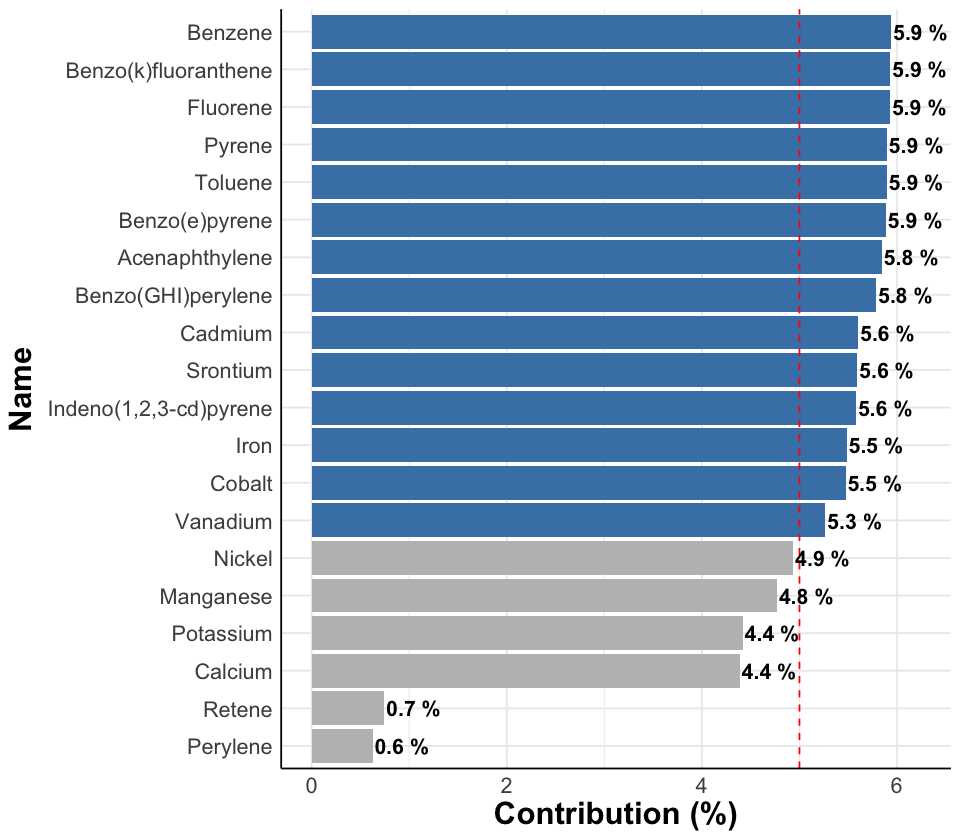

In [18]:
options(repr.plot.width=8, repr.plot.height=7) #changing size
vol_contrib = ggplot(vol_contrib_df, aes(x = Contribution, y = reorder(Variable, Contribution))) + 
  geom_col(aes(fill = Significance)) + 
  geom_vline(xintercept = mean(vol_contrib_df$Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Contribution + 0.3, label = paste(round(Contribution, 1), "%")), fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.position = "none", # removing legend
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

vol_contrib

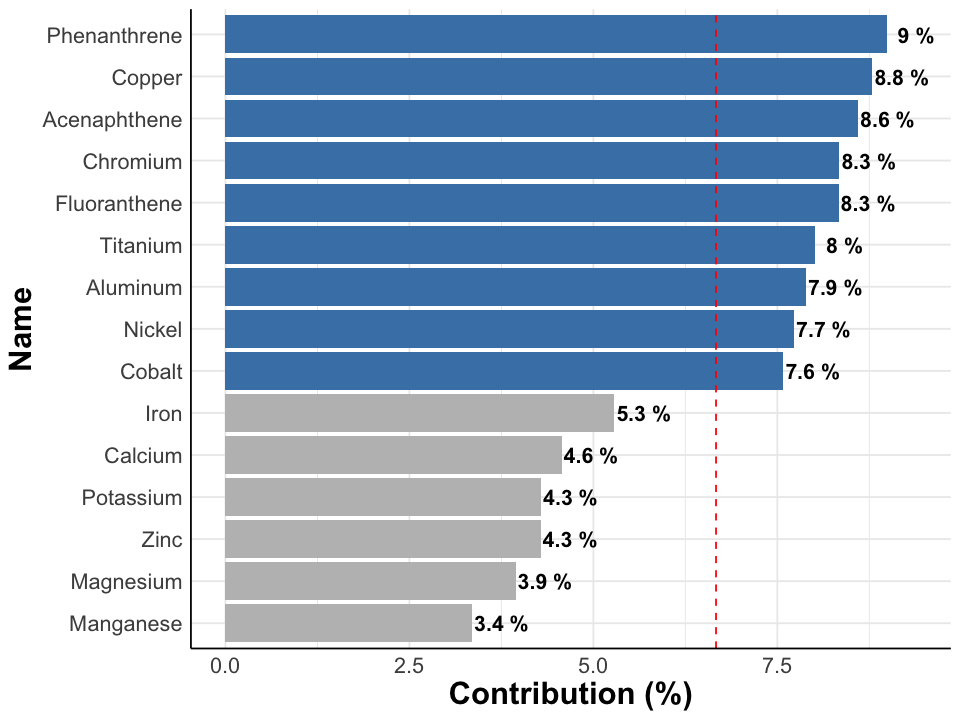

In [19]:
options(repr.plot.width=8, repr.plot.height=6) #changing size
weight_contrib = ggplot(weight_contrib_df, aes(x = Contribution, y = reorder(Variable, Contribution))) + 
  geom_col(aes(fill = Significance)) + 
  geom_vline(xintercept = mean(weight_contrib_df$Contribution), linetype = "dashed", color = "red") + 
  geom_text(aes(x = Contribution + 0.4, label = paste(round(Contribution, 1), "%")), 
            fontface = "bold", size = 4.5) + 

  theme_minimal() + 
  theme(legend.position = "none", # removing legend
      axis.line = element_line(colour="black"), #making x and y axes black
      axis.text = element_text(size = 13), #changing size of x axis labels
      axis.title = element_text(face = "bold", size = rel(1.7))) + #changes axis titles

  labs(x = 'Contribution (%)', y = 'Name') + #changing axis labels 

  scale_fill_manual(values = c('Gray', "Steelblue"))

weight_contrib

In [34]:
# # exporting figures
# ggsave(metal_vol_contrib, 
#        filename = 'metalvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 5)
# ggsave(pah_vol_contrib, 
#        filename = 'pahvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 6)
# ggsave(voc_vol_contrib, 
#        filename = 'vocvol.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 10, height = 5)
# ggsave(metal_weight_contrib, 
#        filename = 'metalweight.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 5)
# ggsave(pah_weight_contrib, 
#        filename = 'pahweight.jpeg',
#        path = Output,
#        # need to respecify dimensions here when exporting figures
#        width = 8, height = 6)